In [1]:
# загрузка пакетов: инструменты -------------------------------------------- # работа с массивами
import numpy as np
# фреймы данных
import pandas as pd
# графики
import matplotlib as mpl
# стили и шаблоны графиков на основе matplotlib
import seaborn as sns
# перекодировка категориальных переменных
from sklearn.preprocessing import LabelEncoder
# тест Шапиро-Уилка на нормальность распределения
from scipy.stats import shapiro
# для таймера
import time
# загрузка пакетов: модели ------------------------------------------------- # линейные модели
import sklearn.linear_model as skl_lm
# расчёт MSE
from sklearn.metrics import mean_squared_error
#  кросс-валидация
from sklearn.model_selection import train_test_split, LeaveOneOut
from sklearn.model_selection import KFold, cross_val_score

In [2]:
# Загрузка констант и глобальных настроек
Train_frac = 0.8
K_VAL = 10
Alpha = 0.05
# ядро для генератора случайных чисел
my_seed = 11
# создаём псевдоним для короткого обращения к графикам
plt = mpl.pyplot
# настройка стиля и отображения графиков
# примеры стилей и шаблонов графиков:
# http://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html mpl.style.use('seaborn-whitegrid')
mpl.style.use('seaborn-whitegrid')
sns.set_palette("Set2")

In [3]:
# читаем таблицу из файла .csv во фрейм
fileURL = 'https://raw.githubusercontent.com/ania607/ML/main/data/Boston_for_lab.csv'

DF_raw = pd.read_csv(fileURL)
# выясняем размерность фрейма
print('Число строк и столбцов в наборе данных:\n', DF_raw.shape)

Число строк и столбцов в наборе данных:
 (506, 15)


In [4]:
# количество пропусков
DF_raw.isna().sum()

crim            0
zn              0
indus           0
chas            0
nox             0
rm              0
age             0
dis             0
rad             0
tax             0
ptratio         0
black           0
lstat           0
medv            0
tax_over_400    0
dtype: int64

Пропусков в столбцах отсутствуют.

In [5]:
# типы столбцов фрейма
DF_raw.dtypes

crim            float64
zn              float64
indus           float64
chas              int64
nox             float64
rm              float64
age             float64
dis             float64
rad               int64
tax               int64
ptratio         float64
black           float64
lstat           float64
medv            float64
tax_over_400      int64
dtype: object

Все столбцы таблицы имеют численное значение.

In [6]:
DF_all = DF_raw[['medv', 'crim', 'indus', 'tax_over_400']]
DF_all 

,medv,crim,indus,tax_over_400
0,24.0,0.00632,2.31,0
1,21.6,0.02731,7.07,0
2,34.7,0.02729,7.07,0
3,33.4,0.03237,2.18,0
4,36.2,0.06905,2.18,0
...,...,...,...,...
501,22.4,0.06263,11.93,0
502,20.6,0.04527,11.93,0
503,23.9,0.06076,11.93,0
504,22.0,0.10959,11.93,0


In [7]:
# данные для построения моделей
DF = DF_all.sample(frac = Train_frac, random_state = my_seed)
# данные для прогнозов
DF_predict = DF_all.drop(DF.index)
del DF_raw

### Предварительный анализ данных 

In [8]:
DF[['medv', 'crim', 'indus']].describe()

,medv,crim,indus
count,405.000000,405.000000,405.000000
mean,22.418272,3.694793,11.266938
std,9.271841,8.335096,6.937377
min,5.000000,0.006320,0.460000
25%,16.600000,0.083700,5.130000
50%,21.200000,0.269380,9.900000
75%,25.000000,3.774980,18.100000
max,50.000000,73.534100,27.740000


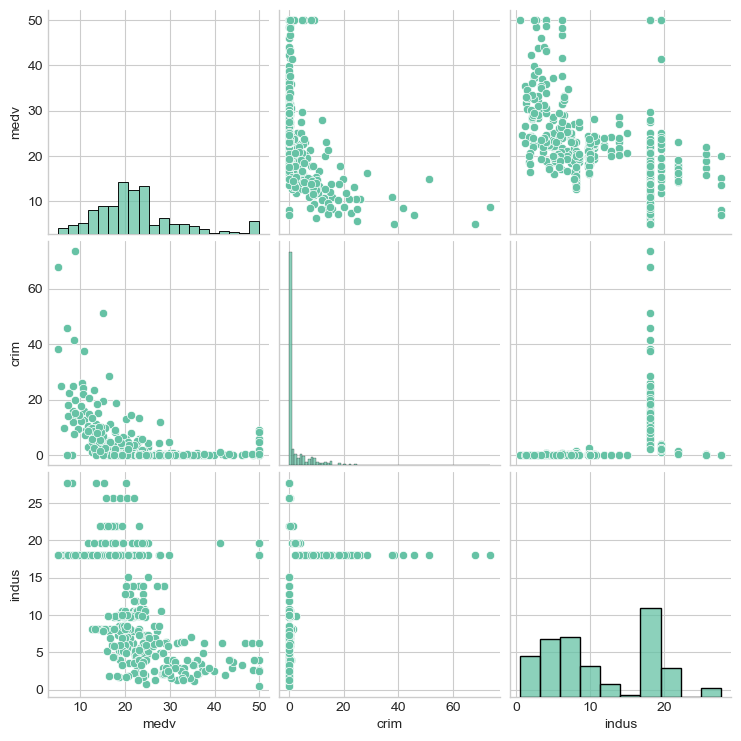

In [9]:
sns.pairplot(DF[['medv', 'crim', 'indus']])
plt.show()

По графикам видно, что распределения переменных отличны от нормального.

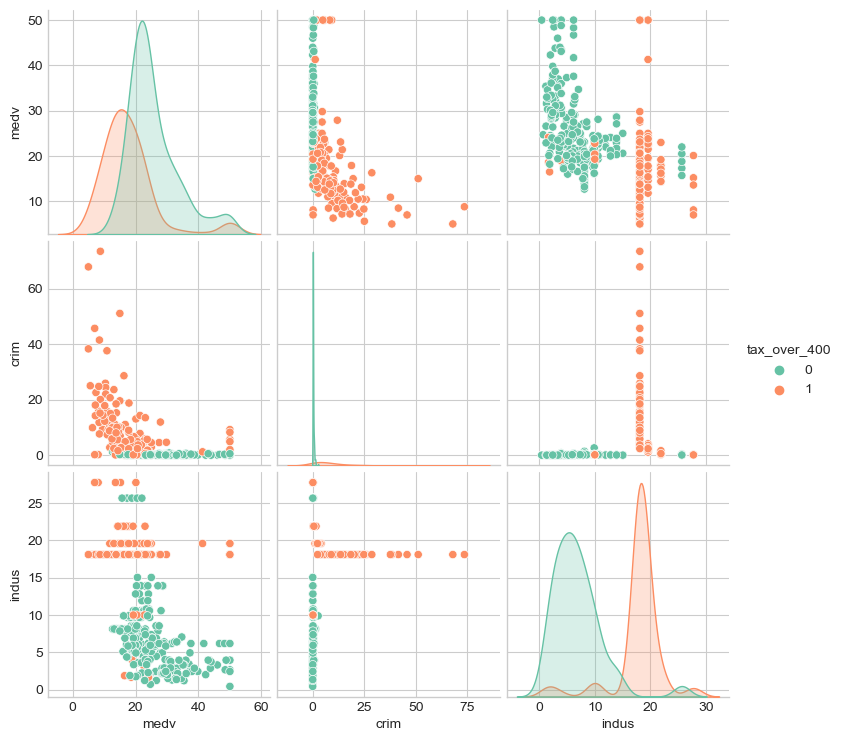

In [10]:
sns.pairplot(DF[['medv', 'crim', 'indus','tax_over_400']], hue='tax_over_400')
plt.show()

Можно предположить, что при превышении 400 полной ставки налога на имущество 1000$ медианная стоимость домов падает.

In [11]:
#Посмотрим на корреляционные матрицы переменных фрейма.
corr_mat = DF[['medv', 'crim', 'indus']].corr()
corr_mat.style.background_gradient(cmap='coolwarm')

,medv,crim,indus
medv,1.000000,-0.416527,-0.496836
crim,-0.416527,1.000000,0.416992
indus,-0.496836,0.416992,1.000000


Максимальная теснота линейной взаимосвязи соответствует коэффицтенту корреляции между medv и indus. Коэффициент равен -0.497, без разбиения на классы наблюдений по фиктивным переменным.

In [12]:
corr_mat = DF.loc[DF['tax_over_400'] == 0][['medv', 'crim', 'indus']].corr()
corr_mat.style.background_gradient(cmap='coolwarm')

,medv,crim,indus
medv,1.000000,-0.194245,-0.408937
crim,-0.194245,1.000000,0.139914
indus,-0.408937,0.139914,1.000000


In [13]:
corr_mat = DF.loc[DF['tax_over_400'] == 1][['medv', 'crim', 'indus']].corr()
corr_mat.style.background_gradient(cmap='coolwarm')

,medv,crim,indus
medv,1.000000,-0.380595,-0.147260
crim,-0.380595,1.000000,0.068346
indus,-0.147260,0.068346,1.000000


Корреляция мнжду эндогенной переменной и экзогенными переменными падает при учете фиктивной переменней.

In [14]:
# Проверим medv на нормальность
stat, p = shapiro(DF['medv'])
print('sales', 'Statistics=%.2f, p=%.4f' % (stat, p)) # интерпретация
alpha = Alpha
if p > alpha:
    print('Распределение нормально (H0 не отклоняется)\n')
else:
    print('Распределение не нормально (H0 отклоняется)\n')

sales Statistics=0.92, p=0.0000
Распределение не нормально (H0 отклоняется)



Распределение зависимой переменной не нормально. Пролагорифмируем зависимую переменную.

In [15]:
# логарифмируем зависимую переменную
DF['log_medv'] = np.log(DF['medv'])
# описательные статистики для непрерывных показателей
DF[['medv', 'log_medv', 'crim', 'indus']].describe()

,medv,log_medv,crim,indus
count,405.000000,405.000000,405.000000,405.000000
mean,22.418272,3.027030,3.694793,11.266938
std,9.271841,0.415610,8.335096,6.937377
min,5.000000,1.609438,0.006320,0.460000
25%,16.600000,2.809403,0.083700,5.130000
50%,21.200000,3.054001,0.269380,9.900000
75%,25.000000,3.218876,3.774980,18.100000
max,50.000000,3.912023,73.534100,27.740000


In [16]:
# тестируем на нормальность
for col in ['medv', 'log_medv']:
 stat, p = shapiro(DF[col])
 print(col, 'Statistics=%.2f, p=%.4f' % (stat, p))
 # интерпретация
 if p > Alpha:
     print('Распределение нормально (H0 не отклоняется)\n')
 else:
     print('Распределение не нормально (H0 отклоняется)\n')


medv Statistics=0.92, p=0.0000
Распределение не нормально (H0 отклоняется)

log_medv Statistics=0.97, p=0.0000
Распределение не нормально (H0 отклоняется)



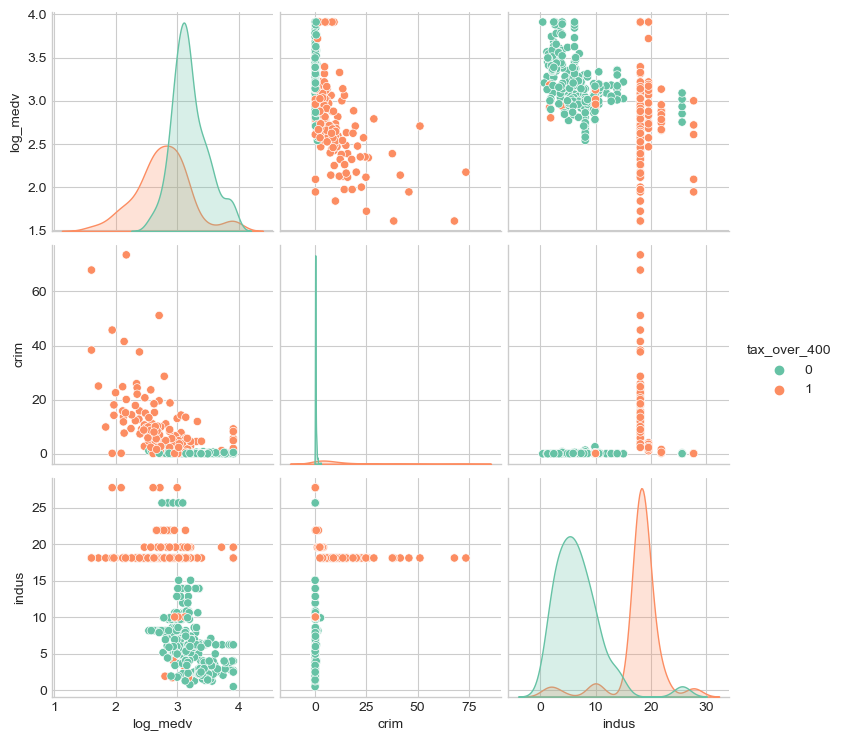

In [17]:
# матричный график разброса с цветом по smokerYes
sns.pairplot(DF[['log_medv',  'crim', 'indus',
 'tax_over_400']], hue='tax_over_400')
plt.show()

Тест Шапиро-Уилка показывает, что после логарифмирования log_medv по-прежнему не распределена нормально, однако функция плотности на графике ниже выглядит более нормальной, чем была у medv . Логарифмирование меняет взаимосвязи между переменными, и, судя по графикам разброса, в нашем случае некоторые стали нелинейными.


### Построим модели регрессии

In [18]:
# Без log
df1 = DF[['medv', 'crim', 'indus']]

df2 = DF[['medv', 'crim', 'tax_over_400', 'indus']]
df2.loc[:, 'crim_tax_over_400'] = df2.loc[:, 'crim'] * df2.loc[:, 'tax_over_400']
df2 = df2.drop(['tax_over_400','crim'], axis=1)

df3 = DF[['medv', 'tax_over_400','crim', 'indus']]
df3.loc[:, 'indus_tax_over_400'] = df3.loc[:, 'indus'] * df3.loc[:, 'tax_over_400']
df3 = df3.drop(['indus', 'tax_over_400'], axis=1)
# С log
df1_log = DF[['log_medv', 'crim', 'indus']]

df2_log = DF[['log_medv', 'crim', 'tax_over_400', 'indus']]
df2_log.loc[:, 'crim_tax_over_400'] = df2_log.loc[:, 'crim'] * df2_log.loc[:, 'tax_over_400']
df2_log = df2_log.drop(['tax_over_400','crim'], axis=1)

df3_log = DF[['log_medv', 'tax_over_400','crim', 'indus']]
df3_log.loc[:, 'indus_tax_over_400'] = df3_log.loc[:, 'indus'] * df3_log.loc[:, 'tax_over_400']
df3_log = df3_log.drop(['indus', 'tax_over_400'], axis=1)

In [19]:
lm = skl_lm.LinearRegression()
X = df1.drop(['medv'], axis=1)
y = df1.medv.values.reshape(-1, 1)
fit_lm_0 = lm.fit(X, y)
print('модель df1 ','константа ', np.around(fit_lm_0.intercept_, 3), '\n объясняющие ', list(X.columns.values),'\n коэффициенты ', np.around(fit_lm_0.coef_, 3))
  

модель df1  константа  [29.35] 
 объясняющие  ['crim', 'indus'] 
 коэффициенты  [[-0.282 -0.523]]


In [20]:
y_pred = fit_lm_0.predict(X)
MSE1 = sum((y - y_pred.reshape(-1, 1))**2) / len(y)
MSE1

array([60.03704865])

In [21]:
lm2 = skl_lm.LinearRegression()
X2 = df2.drop(['medv'], axis=1)
y2 = df2.medv.values.reshape(-1, 1)
fit_lm_2 = lm.fit(X2, y2)
print('модель df2','константа ', np.around(fit_lm_2.intercept_, 3), '\n объясняющие ', list(X2.columns.values),'\n коэффициенты ', np.around(fit_lm_2.coef_, 3))
     

модель df2 константа  [29.29] 
 объясняющие  ['indus', 'crim_tax_over_400'] 
 коэффициенты  [[-0.522 -0.277]]


In [22]:
y_pred2 = fit_lm_2.predict(X2)
MSE2 = sum((y2 - y_pred2.reshape(-1, 1))**2) / len(y2)
MSE2

array([60.16616196])

In [23]:
lm3 = skl_lm.LinearRegression()
X3 = df3.drop(['medv'], axis=1)
y3 = df3.medv.values.reshape(-1, 1)
fit_lm_3 = lm.fit(X3, y3)
print('модель df3 ','константа ', np.around(fit_lm_3.intercept_, 3), '\n объясняющие ', list(X3.columns.values),'\n коэффициенты ', np.around(fit_lm_3.coef_, 3))
     

модель df3  константа  [25.665] 
 объясняющие  ['crim', 'indus_tax_over_400'] 
 коэффициенты  [[-0.301 -0.297]]


In [24]:
y_pred3 = fit_lm_3.predict(X3)
MSE3 = sum((y3 - y_pred3.reshape(-1, 1))**2) / len(y3)
MSE3

array([65.3625263])

In [25]:
lm4 = skl_lm.LinearRegression()
X4 = df1_log.drop(['log_medv'], axis=1)
y4 = df1_log.log_medv.values.reshape(-1, 1)
fit_lm_4 = lm.fit(X4, y4)
print('модель df1_log ','константа ', np.around(np.exp(fit_lm_4.intercept_), 3), '\n объясняющие ', list(X4.columns.values),'\n коэффициенты ', np.around((np.exp(fit_lm_4.coef_) - 1) * 100, 3))
  

модель df1_log  константа  [28.801] 
 объясняющие  ['crim', 'indus'] 
 коэффициенты  [[-2.021 -2.263]]


In [26]:
y_pred4 = fit_lm_4.predict(X4)
MSE4 = sum((y4 - y_pred4.reshape(-1, 1))**2) / len(y4)
MSE4

array([0.09575631])

In [27]:
lm5 = skl_lm.LinearRegression()
X5 = df2_log.drop(['log_medv'], axis=1)
y5 = df2_log.log_medv.values.reshape(-1, 1)
fit_lm_5 = lm.fit(X5, y5)
print('модель df2_log ','константа ', np.around(np.exp(fit_lm_5.intercept_), 3), '\n объясняющие ', list(X5.columns.values),'\n коэффициенты ', np.around((np.exp(fit_lm_5.coef_) - 1) * 100, 3))
  

модель df2_log  константа  [28.67] 
 объясняющие  ['indus', 'crim_tax_over_400'] 
 коэффициенты  [[-2.256 -1.995]]


In [28]:
y_pred5 = fit_lm_5.predict(X3)
MSE5 = sum((y5 - y_pred5.reshape(-1, 1))**2) / len(y5)
MSE5

C:\Users\a_zlo\anaconda3\envs\notebook\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- crim
- indus_tax_over_400
Feature names seen at fit time, yet now missing:
- crim_tax_over_400
- indus

  warnings.warn(message, FutureWarning)


array([0.11773712])

In [29]:
lm6 = skl_lm.LinearRegression()
X6 = df3_log.drop(['log_medv'], axis=1)
y6 = df3_log.log_medv.values.reshape(-1, 1)
fit_lm_6 = lm.fit(X6, y6)
print('модель df3_log ','константа ', np.around(np.exp(fit_lm_6.intercept_), 3), '\n объясняющие ', list(X6.columns.values),'\n коэффициенты ', np.around((np.exp(fit_lm_6.coef_) - 1) * 100, 3))
  

модель df3_log  константа  [24.682] 
 объясняющие  ['crim', 'indus_tax_over_400'] 
 коэффициенты  [[-2.029 -1.423]]


In [30]:
y_pred6 = fit_lm_6.predict(X3)
MSE6 = sum((y6 - y_pred6.reshape(-1, 1))**2) / len(y6)
MSE6

array([0.10364851])

### Оценка точности с помощью K-VAL(10)

In [31]:
# Перекрёстная проверка по 10 блокам
folds = 10
# ядра для разбиений перекрёстной проверкой
r_state = np.arange(my_seed, my_seed + 9)
# модели для y
scores = list()
# таймер
tic = time.perf_counter()
i=0
for df in [df1, df2, df3] :
  X = df.drop(['medv'], axis=1)
  y = df.medv
  kf_10 = KFold(n_splits=folds, random_state=r_state[i],shuffle=True)
  score = cross_val_score(lm, X, y, cv=kf_10,
                          scoring='neg_mean_squared_error').mean()
  scores.append(score)
  i+=1
# таймер

toc = time.perf_counter()
print(f"Расчёты методом CV по 10 блокам заняли {toc - tic:0.2f} секунд")

Расчёты методом CV по 10 блокам заняли 0.09 секунд


In [32]:
fits = ['fit_lm_0', 'fit_lm_2', 'fit_lm_3']
print('Наименьшая ошибка на тестовой с k-fold10 у модели', fits[scores.index(max(scores))], ':\nMSE_kf10 =', np.around(-max(scores), 0))

Наименьшая ошибка на тестовой с k-fold10 у модели fit_lm_2 :
MSE_kf10 = 61.0


In [33]:
# Перекрёстная проверка по 10 блокам
folds = 10
# ядра для разбиений перекрёстной проверкой
r_state = np.arange(my_seed, my_seed + 9)
# модели для y
scores_log = list()
# таймер
tic = time.perf_counter()
i = 0
for df in [df1, df2, df3] :
 X = df.drop(['medv'], axis=1)
 y = np.log(df.medv)
 kf_10 = KFold(n_splits=folds, random_state=r_state[i],
 shuffle=True)
 score = cross_val_score(lm, X, y, cv=kf_10,
 scoring='neg_mean_squared_error').mean()
 scores_log.append(score)
 i+=1
# таймер
toc = time.perf_counter()
print(f"Расчёты методом CV по 10 блокам заняли {toc - tic:0.2f} секунд")


Расчёты методом CV по 10 блокам заняли 0.08 секунд


In [34]:
# самая точная на log(medv)
fits = ['fit_lm_4', 'fit_lm_5', 'fit_lm_6']
print('Наименьшая ошибка на тестовой с k-fold10 у модели',
 fits[scores_log.index(max(scores_log))],
 ':\nMSE_kf10 =', np.around(-max(scores_log), 3))


Наименьшая ошибка на тестовой с k-fold10 у модели fit_lm_5 :
MSE_kf10 = 0.098


Самой точной среди моделей для medv оказалась fit_lm_2  , а среди моделей для  log_medv – fit_lm_5 . Оценим точность прогноза по этим моделям на отложенные наблюдения.


### Оценка точности прогноза по моделям

In [35]:
# прогноз по fit_lm_2
X = df2.drop(['medv'], axis=1)
y = df2.medv.values.reshape(-1, 1)

In [36]:
fit_lm_2 = lm.fit(X, y)
#  значения y на отложенных наблюдениях
y7 = DF_predict[['medv']].values.reshape(-1, 1)
# матрица объясняющих на отложенных наблюдениях
X7 = DF_predict[['crim', 'tax_over_400', 'indus']]
X7.loc[:, 'crim_tax_over_400'] = X7.loc[:, 'crim'] * X7.loc[:, 'tax_over_400']
X7 = X7.drop(['tax_over_400','crim'], axis=1)

# прогнозы
y_pred7 = fit_lm_2.predict(X7)
# ошибка
MSE7 = sum((y7 - y_pred7.reshape(-1, 1))**2) / len(y7)
print('MSE модели fit_lm_2 на отложенных наблюдениях = %.2f' % MSE7)

MSE модели fit_lm_2 на отложенных наблюдениях = 65.14


In [37]:
# прогноз по fit_lm_5
X = df2_log.drop(['log_medv'], axis=1)
y = df2_log.log_medv.values.reshape(-1, 1)
fit_lm_5 = lm.fit(X, y)

#  значения y на отложенных наблюдениях
y8 = DF_predict[['medv']].values.reshape(-1, 1)
# матрица объясняющих на отложенных наблюдениях
X8 = DF_predict[['crim', 'tax_over_400', 'indus']]
X8.loc[:, 'crim_tax_over_400'] = X8.loc[:, 'crim'] * X8.loc[:, 'tax_over_400']
X8 = X8.drop(['tax_over_400','crim'], axis=1)

# прогнозы
y_pred8 = fit_lm_5.predict(X7)
# ошибка
MSE8 = sum((y8 - y_pred8.reshape(-1, 1))**2) / len(y8)
print('MSE модели fit_lm_5 на отложенных наблюдениях = %.2f' % MSE8)

MSE модели fit_lm_5 на отложенных наблюдениях = 474.45


### Прогноз по лучшей модели

In [41]:
X = df2_log.drop(['medv'], axis=1)
y = df2_log.medv.values.reshape(-1, 1)
fit_lm_5 = lm.fit(X, y)

# делаем данные для модели из отложенных наблюдений
df2_log = DF_predict[['medv', 'crim', 'tax_over_400', 'indus']]
df2_log.loc[:, 'crim_tax_over_400'] = df2_log.loc[:, 'crim'] * df2_log.loc[:, 'tax_over_400']
df2_log = df2_log.drop(['tax_over_400','crim'], axis=1)

X9 = df2_log.drop(['medv'], axis=1)
y9 = df2_log.medv.values.reshape(-1, 1)
# прогноз
y_pred9 = fit_lm_5.predict(X9)
# ошибка
MSE9 = sum((y9 - y_pred9.reshape(-1, 1))**2) / len(y9)
np.around(MSE9, 2)

C:\Users\a_zlo\anaconda3\envs\notebook\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


array([63.17])

In [42]:
print('Ошибка модели на отложенных наблюдениях составила ', np.around(np.sqrt(MSE5) / np.mean(y5) * 100, 1)[0],'% от среднего значения Y', sep='')
     

Ошибка модели на отложенных наблюдениях составила 11.3% от среднего значения Y
